In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re 
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

data = pd.read_csv("Obama1516Clustered.csv")
data.drop("Unnamed: 0",inplace=True,axis=1)

vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores
data.drop(["text","modded_text","modded1"],axis=1,inplace=True)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
data

,date_year,week_year,date_month,noTags_punct,modded1_stemmed,labels,vaderScore
0,2015,1,1,happy new year,happi new year,0,0.6114
1,2015,1,1,more than 26 million new jobs 10 million ame...,26 million new job 10 million american ...,2,0.6597
2,2015,1,1,check out the top 10 white house series from...,check top 10 white hous seri 2014 dete...,0,0.4939
3,2015,1,1,watch this if you love behindthescenes moments...,watch love behindthescen moment presid o...,9,0.6369
4,2015,1,1,student filmmakers submit your 3min video on t...,student filmmak submit 3min video impact...,1,0.3400
5,2015,1,1,2014 in review president obama became the 1st ...,2014 review presid obama becam 1st pres...,9,0.0000
6,2015,1,1,presssec on president obama imposing additiona...,presssec presid obama impos addit sancti...,9,0.4019
7,2015,1,1,good news minimum wage increases in 20 states ...,good news minimum wage increas 20 state...,6,0.7096
8,2015,1,1,watch the weekly address from the vp on making...,watch weekli address vp make 2015 year ...,1,0.0000
9,2015,1,1,last year almost 7 million people signed up fo...,last year almost 7 million peopl sign ...,0,0.4939


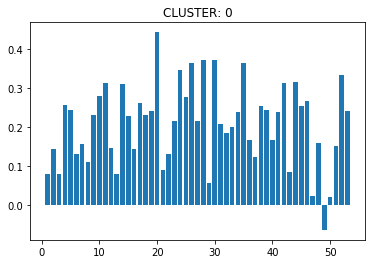

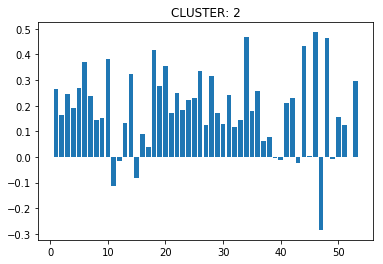

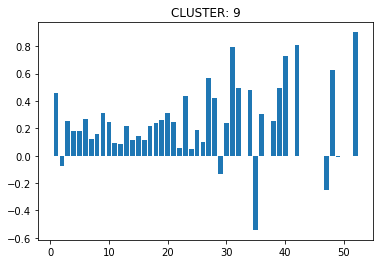

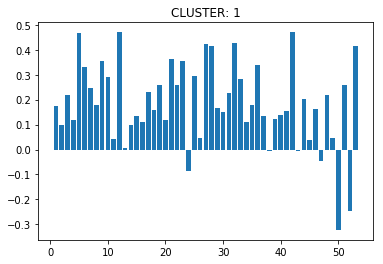

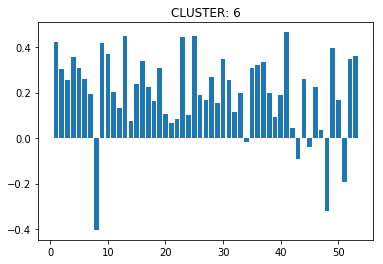

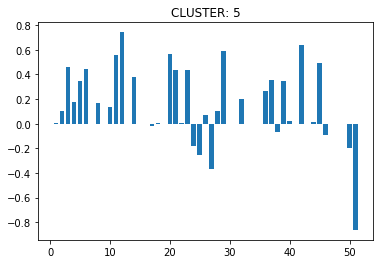

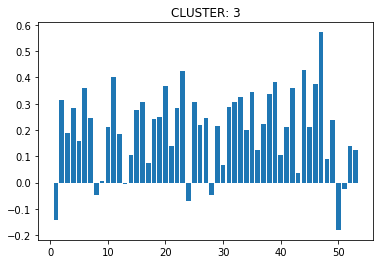

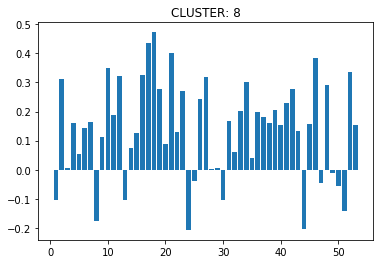

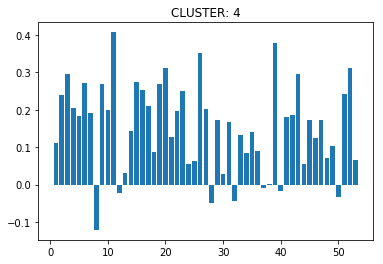

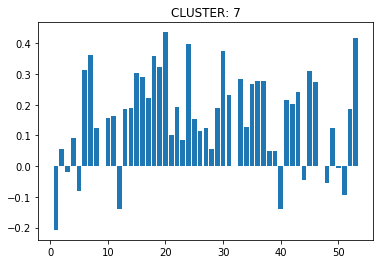

In [4]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()

In [11]:
x1 = data[data["labels"] == 2]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
   
stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]

x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(str(x) for x in x.split() if str(x) in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

633


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


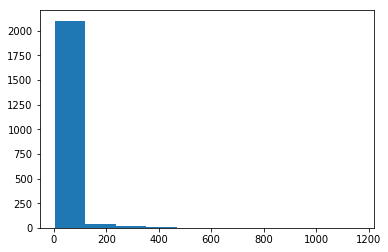

Index(['date_year', 'week_year', 'vaderScore', '10', '10000', '100000',
       '100th', '11', '1110am', '12',
       ...
       'yesterday', 'york', 'yosemit', 'youll', 'young', 'your',
       'youtubeasksobama', 'youv', 'zero', 'zika'],
      dtype='object', length=1446)

In [13]:
plt.hist(stemmed_words)
plt.show()

x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!! sembra che il tempo peggiori sse e migliori silhouette
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels",],axis=1) 
#dataWithText = res
res1.columns

In [15]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels",],axis=1) 

sil = []
for c in range(10,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

10 0.6123701318246276
11 0.5824197277127364
12 0.5617348805103654
13 0.572248659033293
14 0.5584727917503147
15 0.5556536543247742
16 0.5325490231077677
17 0.5217908588896113
18 0.521766900729865
19 0.5123373732381968
20 0.48910445251584517
21 0.4898078948433919


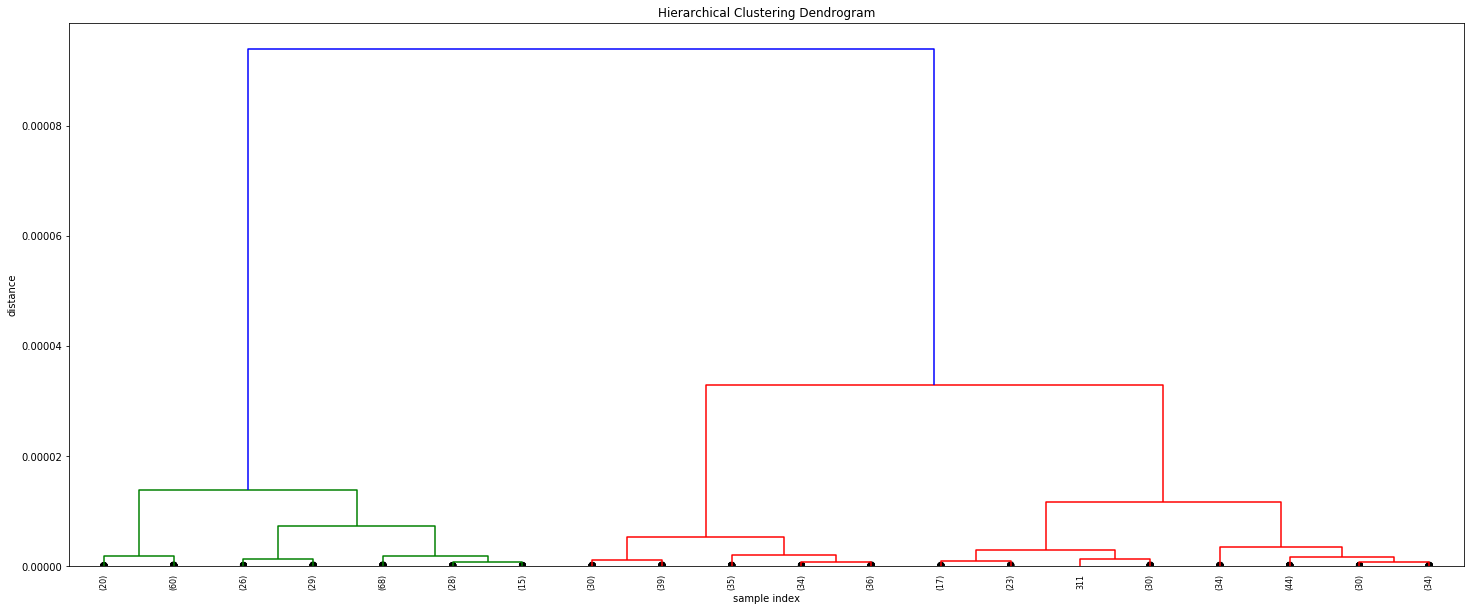

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(res1, 'average', "cosine")
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=20,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [20]:
res1 = res.drop(["date_month","hour","noTags_punct","modded1_stemmed","labels","m"],axis=1)
dataWithText = res.drop(["hour","noTags_punct","modded1_stemmed","labels",],axis=1) 
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=15) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'week_year', 'vaderScore', '10', '10000', '100000',
       '100th', '11', '1110am', '12',
       ...
       'yesterday', 'york', 'yosemit', 'youll', 'young', 'your',
       'youtubeasksobama', 'youv', 'zero', 'zika'],
      dtype='object', length=1446)
0.5556536543247742


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  8  lunghezza  60
NUMBER OF TOPICS FOR CLUSTER  8  :  1


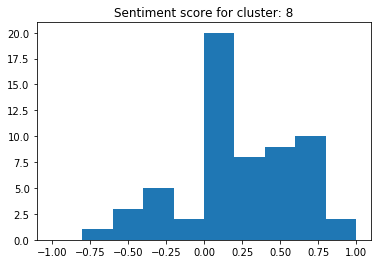

[2015, 2016]
[1]


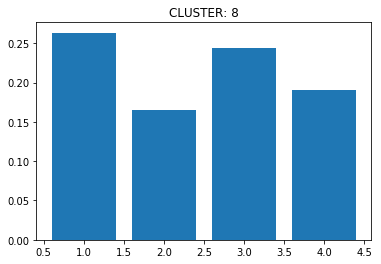

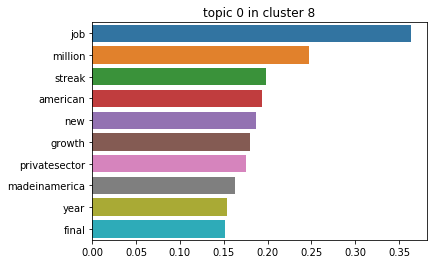

cluster  11  lunghezza  20
NUMBER OF TOPICS FOR CLUSTER  11  :  3


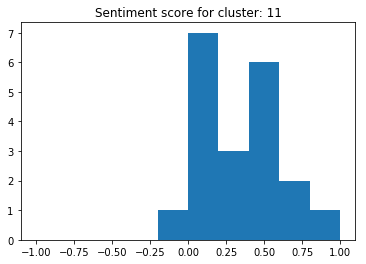

[2015, 2016]
[1, 2]


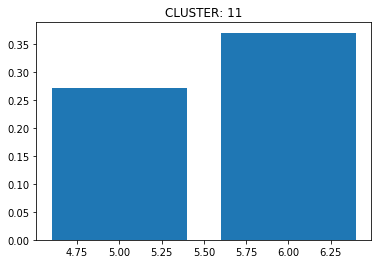

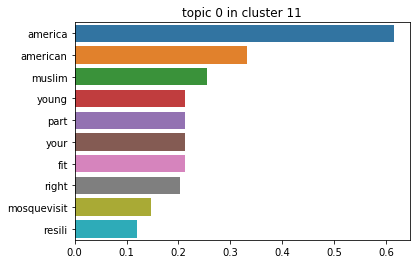

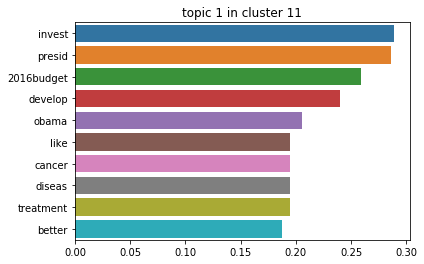

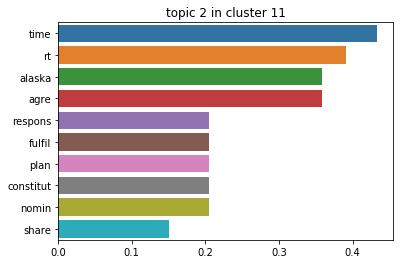

cluster  10  lunghezza  68
NUMBER OF TOPICS FOR CLUSTER  10  :  1


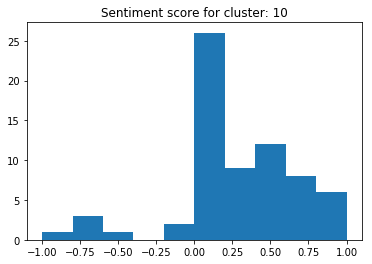

[2015, 2016]
[2, 3]


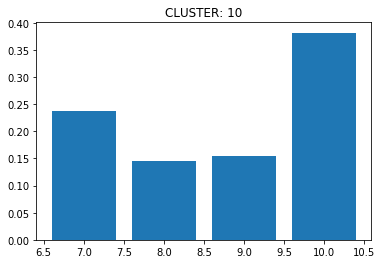

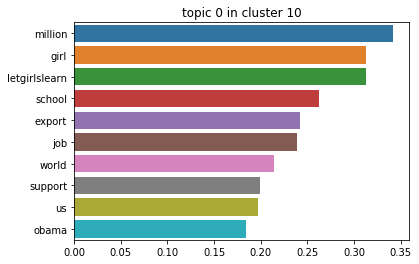

cluster  4  lunghezza  43
NUMBER OF TOPICS FOR CLUSTER  4  :  1


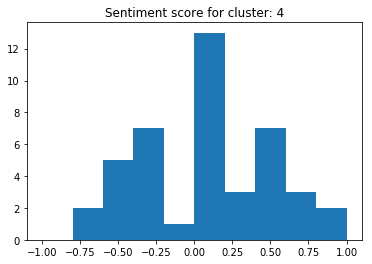

[2015, 2016]
[3, 4]


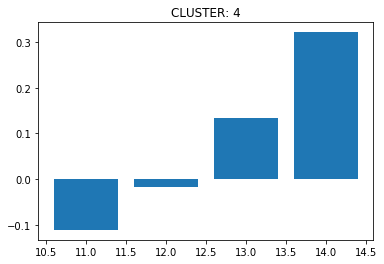

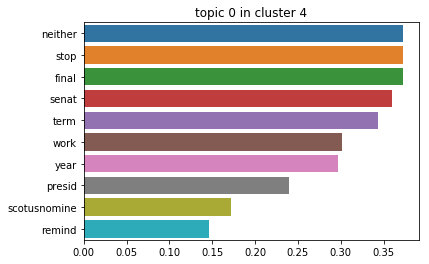

cluster  14  lunghezza  26
NUMBER OF TOPICS FOR CLUSTER  14  :  1


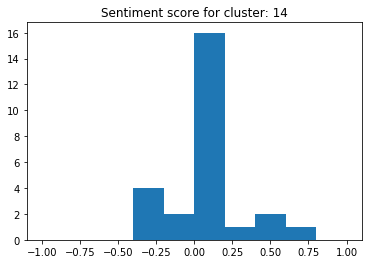

[2015, 2016]
[4, 5]


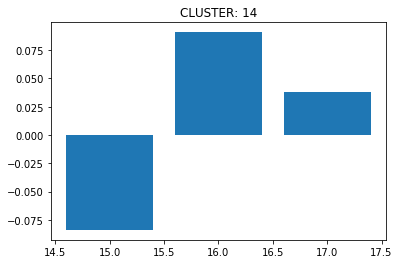

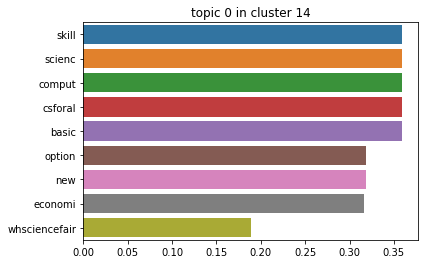

cluster  12  lunghezza  29
NUMBER OF TOPICS FOR CLUSTER  12  :  1


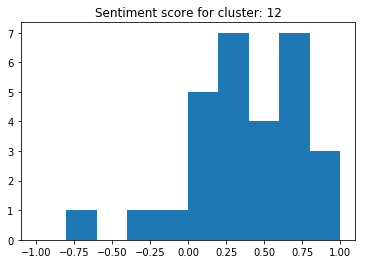

[2015, 2016]
[4, 5]


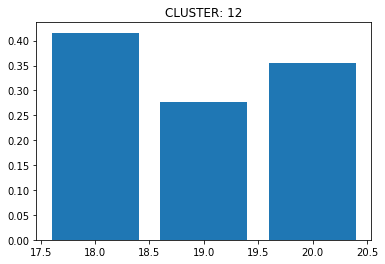

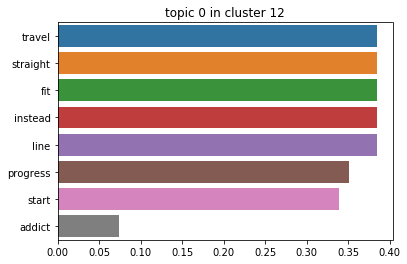

cluster  9  lunghezza  35
NUMBER OF TOPICS FOR CLUSTER  9  :  9


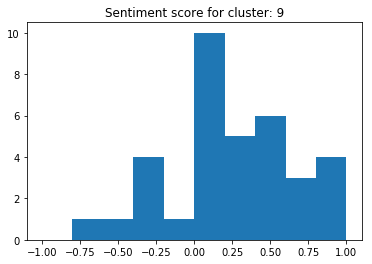

[2015, 2016]
[5, 6]


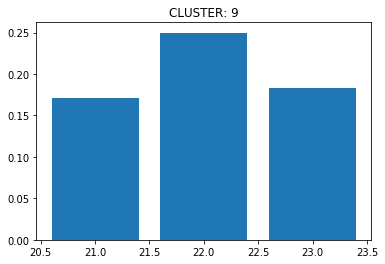

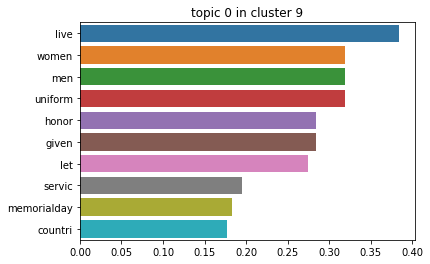

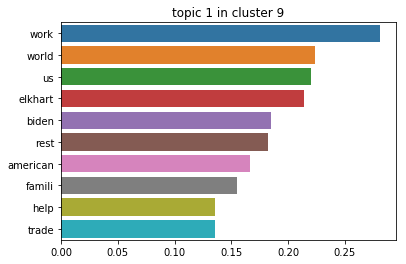

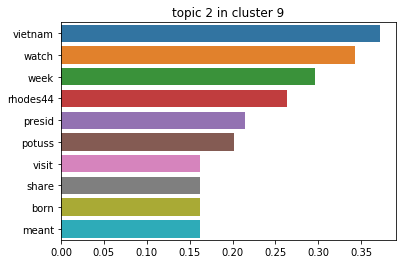

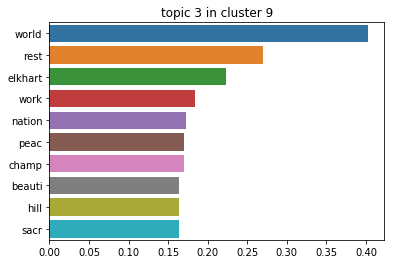

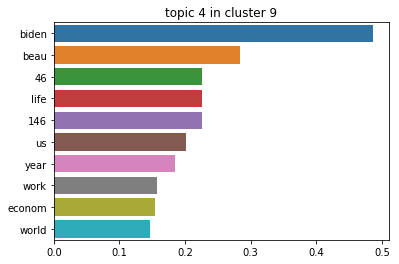

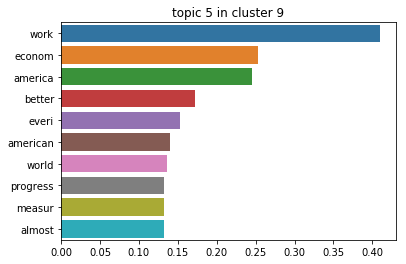

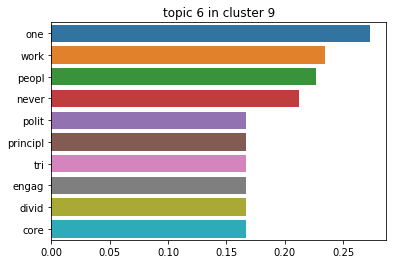

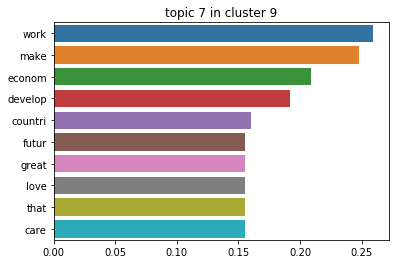

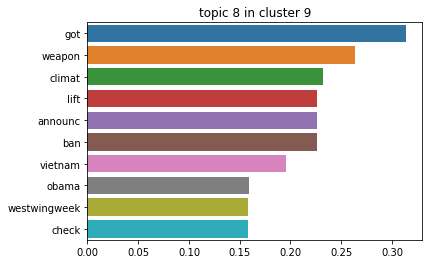

cluster  2  lunghezza  70
NUMBER OF TOPICS FOR CLUSTER  2  :  1


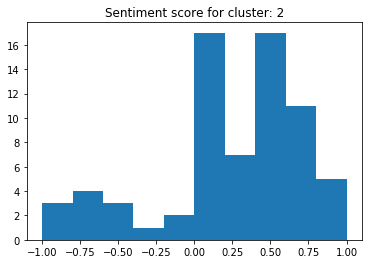

[2015, 2016]
[6, 7]


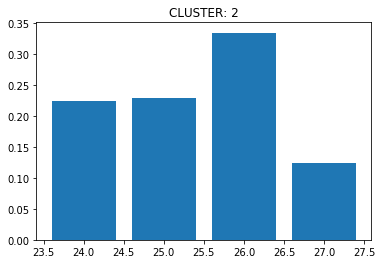

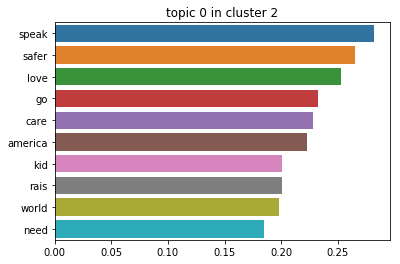

cluster  0  lunghezza  69
NUMBER OF TOPICS FOR CLUSTER  0  :  4


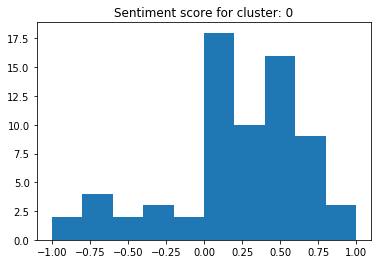

[2015, 2016]
[7, 8]


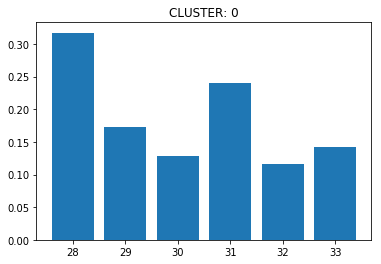

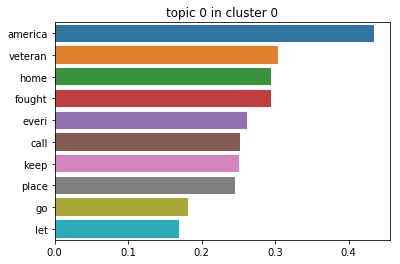

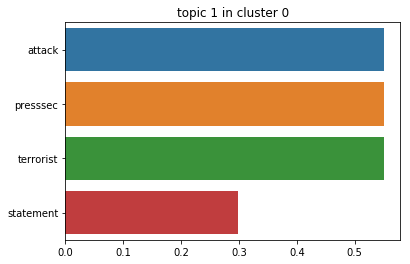

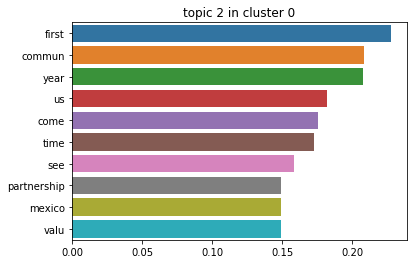

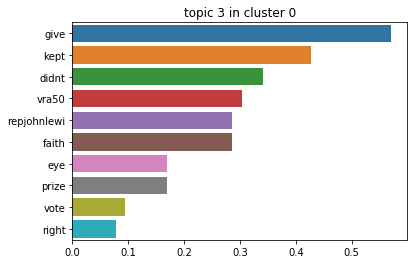

cluster  7  lunghezza  34
NUMBER OF TOPICS FOR CLUSTER  7  :  4


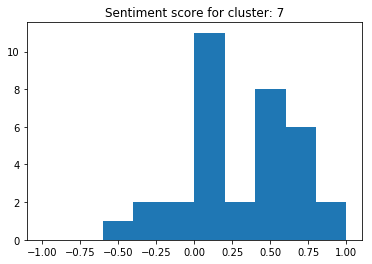

[2015, 2016]
[8, 9]


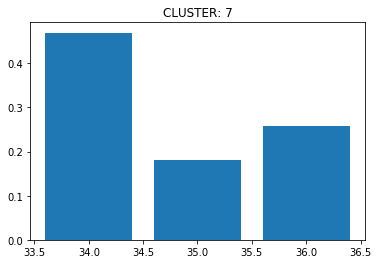

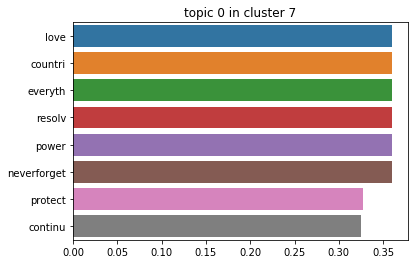

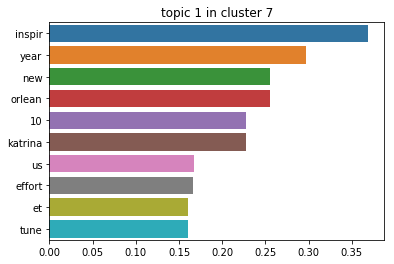

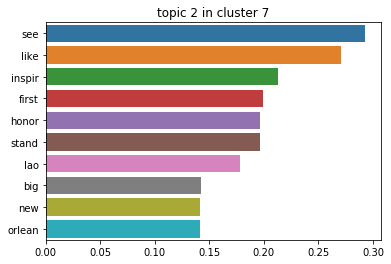

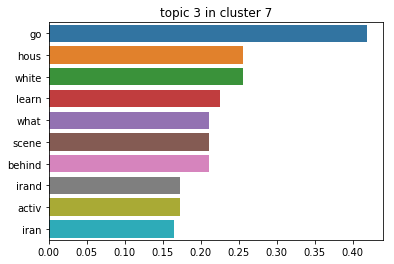

cluster  3  lunghezza  64
NUMBER OF TOPICS FOR CLUSTER  3  :  1


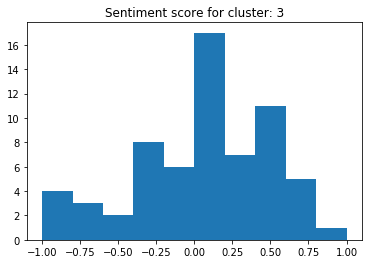

[2015, 2016]
[9, 10]


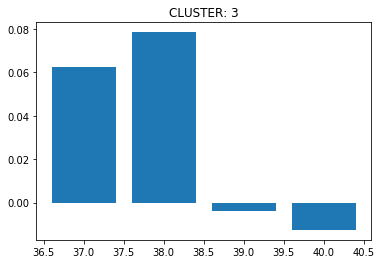

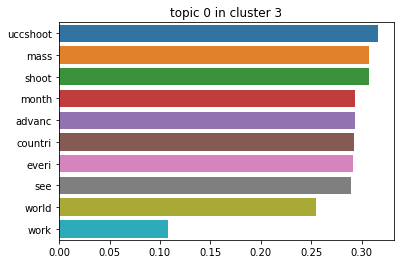

cluster  5  lunghezza  44
NUMBER OF TOPICS FOR CLUSTER  5  :  1


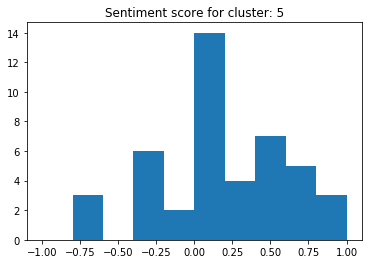

[2015, 2016]
[10]


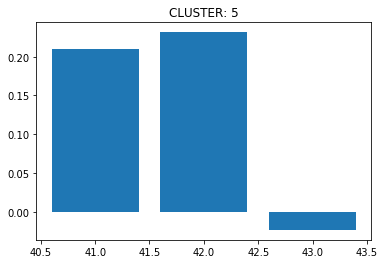

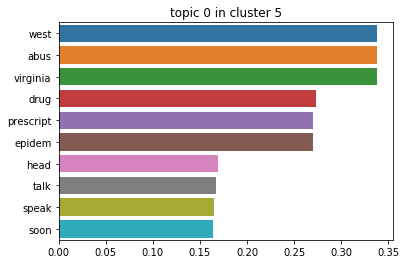

cluster  1  lunghezza  40
NUMBER OF TOPICS FOR CLUSTER  1  :  4


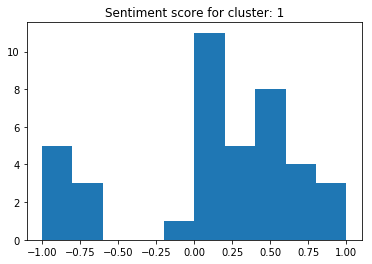

[2015, 2016]
[10, 11]


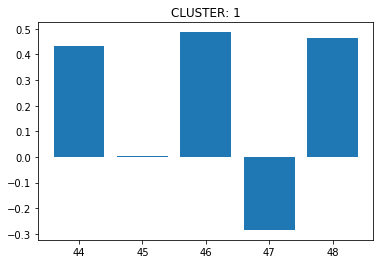

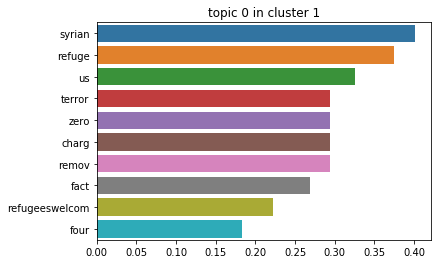

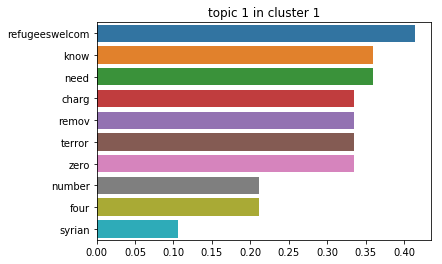

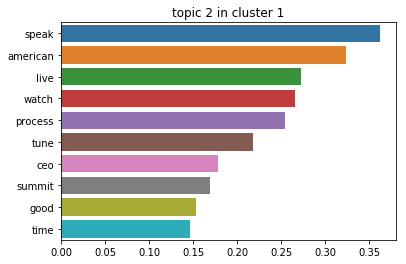

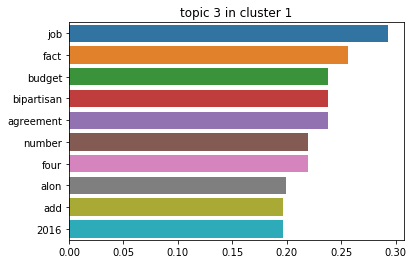

cluster  6  lunghezza  30
NUMBER OF TOPICS FOR CLUSTER  6  :  2


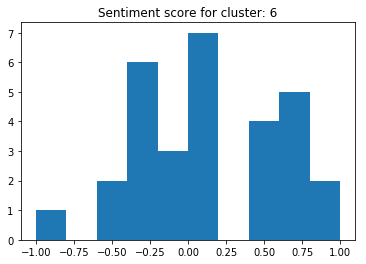

[2015]
[11, 12]


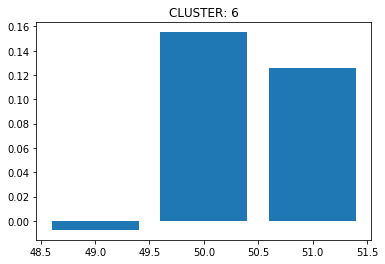

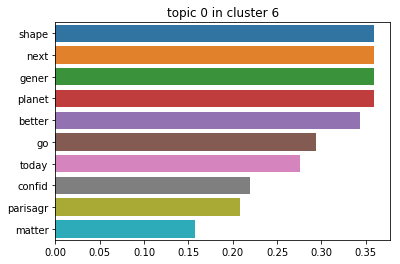

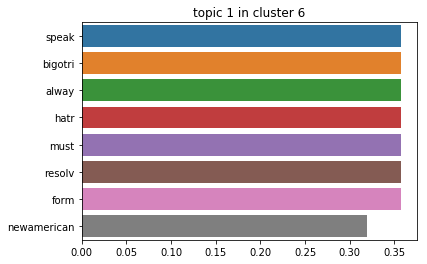

In [21]:
res1["labels"] = labels
dataWithText["labels"] = labels

g = res1.drop(["vaderScore"],axis=1)

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        dictionary = corpora.Dictionary(corp)
        doc_term_matrix = [dictionary.doc2bow(doc) for doc in corp]
        tfidf = TfidfModel(doc_term_matrix)
        tfidf_corpus = tfidf[doc_term_matrix]

        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)
        words = 7
        lsamodel = LsiModel(tfidf_corpus, num_topics=nTopics, id2word = dictionary)  # train model
        #print(lsamodel.show_topics(num_topics = -1,num_words = words))

        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["date_year"].unique().tolist())
        print(d1["date_month"].unique().tolist())
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()
        
        
        #piechart
        topics = lsamodel.show_topics(num_topics=-1, num_words=10, log=True, formatted=False)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.05:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            #manca il pie o la rappresentazione
            sns.barplot(x=weights, y=words)
            plt.show()